In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from medmnist import BloodMNIST

2025-04-27 09:07:15.736327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745759235.935306   17784 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745759235.961817   17784 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745759236.159590   17784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745759236.159707   17784 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745759236.159713   17784 computation_placer.cc:177] computation placer alr

In [ ]:
import random
import os

def set_seed(seed=123):
    os.environ['PYTHONHASHSEED'] = str(seed)  
    random.seed(seed)                         
    np.random.seed(seed)                      
    tf.random.set_seed(seed)                  

set_seed(123)

## Resolution: 64x64

### ResNet50_64

In [ ]:
# 1. Load dataset
data_64 = np.load("bloodmnist_64.npz")

# 2. Extract images and labels
train_images_64 = data_64["train_images"]
train_labels_64 = data_64["train_labels"].flatten()

val_images_64 = data_64["val_images"]
val_labels_64 = data_64["val_labels"].flatten()

test_images_64 = data_64["test_images"]
test_labels_64 = data_64["test_labels"].flatten()

In [ ]:
data_64.files

In [ ]:
# 3. One-hot encode labels
train_labels_cat_64 = to_categorical(train_labels_64, num_classes=8)
val_labels_cat_64 = to_categorical(val_labels_64, num_classes=8)
test_labels_cat_64 = to_categorical(test_labels_64, num_classes=8)

In [ ]:
# 4. Image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32 # increase batch size to 32 from 16

train_generator_64 = train_datagen.flow(
    train_images_64, 
    train_labels_cat_64,   
    batch_size=batch_size
)
val_generator_64 = test_datagen.flow(
    val_images_64,
    val_labels_cat_64,
    batch_size=batch_size
)
test_generator_64 = test_datagen.flow(
    test_images_64,
    test_labels_cat_64,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)

# try diffeent drop out rate
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

In [ ]:
# 6. Compile model 

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

In [ ]:
# 8. Evaluate model
test_loss_50_128, test_acc_50_128, test_auc_50_128 = model_50_128.evaluate(test_generator_128)
print(f"ResNet50 test accuracy for 128 pixels: {test_acc_50_128:.4f}")
print(f"ResNet50 test AUC for 128 pixels:      {test_auc_50_128:.4f}")

In [ ]:
# 9. Precision, recall, f1-score
y_prob_50_128 = model_50_128.predict(test_generator_128)
y_pred_50_128 = np.argmax(y_prob_50_128, axis=1)
y_true_128 = test_labels_128

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}

class_names = [label_dict[str(i)] for i in range(8)]
print(classification_report(y_true_128, y_pred_50_128, target_names=class_names))

In [ ]:
# 10. Performance per class
cm_50_128 = confusion_matrix(y_true_128, y_pred_50_128)
per_class_acc_50_128 = cm_50_128.diagonal() / cm_50_128.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_128):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

In [ ]:
# 11. Plot
epochs = range(1, len(history_50_128.history['loss']) + 1)

# accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history_50_128.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (128x128) - Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_plot_resnet50_128.png")
plt.show()

# auc
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['auc'], label='Training AUC')
plt.plot(epochs, history_50_128.history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (128x128) - AUC vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("auc_plot_resnet50_128.png")
plt.show()

# loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, history_50_128.history['loss'], label='Training Loss')
plt.plot(epochs, history_50_128.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (128x128) - Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot_resnet50_128.png")
plt.show()

In [ ]:
## Comparison: dropout rate

In [12]:
print("model_50_64, dropout rate 0.5")

# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)

# try diffeent drop out rate
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

# 6. Compile model 
from sklearn.utils.class_weight import compute_class_weight

# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64_2 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

model_50_64, dropout rate 0.5
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5550 - auc: 0.8026 - loss: 5.7412

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.5554 - auc: 0.8029 - loss: 5.7325 - val_accuracy: 0.0905 - val_auc: 0.5000 - val_loss: 2532.3105
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.8884 - auc: 0.9836 - loss: 0.4151 - val_accuracy: 0.1104 - val_auc: 0.4849 - val_loss: 42.6389
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.9149 - auc: 0.9900 - loss: 0.3144 - val_accuracy: 0.9165 - val_auc: 0.9906 - val_loss: 0.6510
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.9296 - auc: 0.9945 - loss: 0.2056 - val_accuracy: 0.9433 - val_auc: 0.9933 - val_loss: 0.3160
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.9441 - auc: 0.9950 - loss: 0.1753 - val_accuracy: 0.9609 - val_auc: 0.9949 - val_loss: 0.3312
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 604s 2s/step - accuracy: 0.9385 - auc: 0.9930 - loss: 0.2776 - val_accuracy: 0.9492 - val_auc: 0.9934 - val_loss: 0.2477
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 5

In [7]:
print("model_50_64, dropout rate 0.4")

# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)

# try diffeent drop out rate
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

# 6. Compile model 
# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64_2 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

model_50_64, dropout rate 0.4


2025-04-25 02:48:07.052099: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 642s 2s/step - accuracy: 0.6073 - auc: 0.8324 - loss: 4.6829 - val_accuracy: 0.0952 - val_auc: 0.4990 - val_loss: 4658.5640
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.8922 - auc: 0.9847 - loss: 0.4210 - val_accuracy: 0.1495 - val_auc: 0.5021 - val_loss: 33.5754
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.9266 - auc: 0.9927 - loss: 0.2377 - val_accuracy: 0.9141 - val_auc: 0.9893 - val_loss: 0.7527
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - accuracy: 0.9413 - auc: 0.9946 - loss: 0.2006 - val_accuracy: 0.9451 - val_auc: 0.9931 - val_loss: 0.5544
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.9453 - auc: 0.9952 - loss: 0.1945 - val_accuracy: 0.9077 - val_auc: 0.9852 - val_loss: 0.3904
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.9430 - auc: 0.9948 - loss: 0.1868 - val_accuracy: 0.9433 - val_auc: 0.9944 - val_loss: 0.1708
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 6

In [13]:
print("model_50_64, dropout rate 0.3")

# 5. Set up ResNet50 
base_50_64 = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(64, 64, 3)
)

x = base_50_64.output

x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
attention = layers.Attention()([x_reshape, x_reshape])
attention_output = layers.Reshape(x.shape[1:])(attention)

x = layers.Multiply()([x, attention_output])
x = layers.GlobalAveragePooling2D()(x)

# try diffeent drop out rate
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(8, activation="softmax")(x)

model_50_64 = Model(inputs=base_50_64.input, outputs=outputs)

# 6. Compile model 
# class-weighted loss
class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
class_weight_dict = dict(enumerate(class_weights))

model_50_64.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",       
    metrics=[
        "accuracy",
        AUC(name="auc", multi_label=True, num_labels=8)
    ]
)

# 7. Train model, capture history for plotting
history_50_64_2 = model_50_64.fit(
    train_generator_64,
    epochs=10,
    validation_data=val_generator_64,
    class_weight=class_weight_dict
)

model_50_64, dropout rate 0.3
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - accuracy: 0.6163 - auc: 0.8423 - loss: 4.1851 - val_accuracy: 0.0707 - val_auc: 0.4992 - val_loss: 6462.3911
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 541s 1s/step - accuracy: 0.9035 - auc: 0.9889 - loss: 0.3552 - val_accuracy: 0.1425 - val_auc: 0.5112 - val_loss: 78.5206
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 536s 1s/step - accuracy: 0.9020 - auc: 0.9886 - loss: 0.5956 - val_accuracy: 0.8879 - val_auc: 0.9913 - val_loss: 0.3261
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9313 - auc: 0.9936 - loss: 0.2221 - val_accuracy: 0.9603 - val_auc: 0.9978 - val_loss: 0.1116
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9493 - auc: 0.9961 - loss: 0.1564 - val_accuracy: 0.9626 - val_auc: 0.9967 - val_loss: 0.1276
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.9590 - auc: 0.9975 - loss: 0.1168 - val_accuracy: 0.9708 - val_auc: 0.9979 - val_loss: 0.0998


In [ ]:
## Comparison: optimisers (RMSprop vs SGD with momentums = 0.9)

# dictionary to store history for ResNet50 (64x64)
print("ResNet50 (64x64): training with SGD and RMSpropo, batch size 32, dropout rate 0.4")

histories_50_64 = {}

optimizers = {
    "RMSprop": RMSprop(learning_rate=1e-4),
    "SGD_0.9": SGD(learning_rate=1e-3, momentum=0.9),
    "SGD_0.8": SGD(learning_rate=1e-3, momentum=0.8), # did not load successfully
    "SGD_0.0": SGD(learning_rate=1e-3, momentum=0.0) # did not load successfully
}

for name, optimizer in optimizers.items():
    print(f"\n Training with {name}")

    # define model
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(64, 64, 3)
    )
    
    x = base.output

    # prepare attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)
    
    x = layers.Multiply()([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output) # model built

    # compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    # class weighted loss 
    class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
    class_weight_dict = dict(enumerate(class_weights))

    # train the model
    history_50_64 = model.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        class_weight=class_weight_dict,
        verbose=1
    )

    # evaluate 
    test_loss, test_acc, test_auc = model.evaluate(test_generator_64)
    
    print(f"{name} - Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")

    # save history based on optimiser
    histories_50_64[name] = {"history": history_50_64,
                             "test_acc": test_acc,
                             "test_auc": test_auc}

ResNet50 (64x64): training with SGD and RMSpropo, batch size 32, dropout rate 0.4

 Training with RMSprop


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.6533 - auc: 0.8575 - loss: 3.8373 - val_accuracy: 0.1945 - val_auc: 0.5000 - val_loss: 84468.1328
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.9254 - auc: 0.9919 - loss: 0.3635 - val_accuracy: 0.1390 - val_auc: 0.5013 - val_loss: 4081.1292
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.9509 - auc: 0.9941 - loss: 0.2556 - val_accuracy: 0.8867 - val_auc: 0.9800 - val_loss: 0.4495
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.9569 - auc: 0.9965 - loss: 0.1452 - val_accuracy: 0.9585 - val_auc: 0.9883 - val_loss: 0.4473
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 598s 2s/step - accuracy: 0.9632 - auc: 0.9978 - loss: 0.1201 - val_accuracy: 0.9474 - val_auc: 0.9920 - val_loss: 0.1889
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.9720 - auc: 0.9976 - loss: 0.1477 - val_accuracy: 0.9755 - val_auc: 0.9949 - val_loss: 0.1293
Epoch 7/10
374/374 ━━━━━━━━

In [7]:
# Comparison: SGD optimiser with different momentums + Adam(1e-4)

print("ResNet50 (64x64): training with SGD of different momentum, batch size 32, dropout rate 0.4")

histories_50_64 = {}

optimizers = {
    "Adam": Adam(1e-4),
    "SGD_0.8": SGD(learning_rate=1e-3, momentum=0.8),
    "SGD_0.7": SGD(learning_rate=1e-3, momentum=0.7),
    "SGD_0.5": SGD(learning_rate=1e-3, momentum=0.5)
}

for name, optimizer in optimizers.items():
    print(f"\n Training with {name}")

    # define model
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(64, 64, 3)
    )
    
    x = base.output

    # prepare attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)
    
    x = layers.Multiply()([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output) # model built

    # compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    # class weighted loss 
    class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_labels_64), y=train_labels_64)
    class_weight_dict = dict(enumerate(class_weights))

    # train the model
    history_50_64 = model.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        class_weight=class_weight_dict,
        verbose=1
    )

    # evaluate 
    test_loss, test_acc, test_auc = model.evaluate(test_generator_64)
    
    print(f"{name} - Accuracy: {test_acc:.4f}, AUC: {test_auc:.4f}")

    # save history based on optimiser
    histories_50_64[name] = {"history": history_50_64,
                             "test_acc": test_acc,
                             "test_auc": test_auc}

ResNet50 (64x64): training with SGD of different momentum, batch size 32, dropout rate 0.4

 Training with Adam
Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 837s 2s/step - accuracy: 0.6197 - auc: 0.8406 - loss: 4.2051 - val_accuracy: 0.0771 - val_auc: 0.4873 - val_loss: 2359.9211
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 678s 2s/step - accuracy: 0.8956 - auc: 0.9881 - loss: 0.3347 - val_accuracy: 0.0870 - val_auc: 0.4980 - val_loss: 21.3171
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 723s 2s/step - accuracy: 0.9324 - auc: 0.9941 - loss: 0.2300 - val_accuracy: 0.8978 - val_auc: 0.9913 - val_loss: 0.2924
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.9399 - auc: 0.9948 - loss: 0.1848 - val_accuracy: 0.9574 - val_auc: 0.9951 - val_loss: 0.1422
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 716s 2s/step - accuracy: 0.9484 - auc: 0.9957 - loss: 0.1662 - val_accuracy: 0.9071 - val_auc: 0.9852 - val_loss: 0.8062
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 709s 2s/step - accuracy: 0.8875 - auc: 0.9846 - loss: 0.5887 - val_accuracy: 0.9287 - val_auc: 0.9893 - val_loss: 0.2543
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 7

In [ ]:
# Comparison: Different optimisers with different learning rates

print("ResNet50 (64x64): RMSprop, different learning rates, batch size 32, dropout rate 0.4")

# dictionary to store history for ResNet50 (64x64)
histories_50_64 = {}

# now trying different learning rates too
optimizers = {
    "SGD_lr1e-3_mom0.5": SGD(learning_rate=1e-2, momentum=0.5),  
    "SGD_lr1e-4_mom0.5": SGD(learning_rate=1e-4, momentum=0.5),
    "Adam_lr1e-2": Adam(learning_rate=1e-2),
    "Adam_lr1e-3": Adam(learning_rate=1e-3),
    "Adam_lr1e-5": Adam(learning_rate=1e-5),
    "RMSprop_lr1e-2": RMSprop(learning_rate=1e-2),
    "RMSprop_lr1e-3": RMSprop(learning_rate=1e-3),
    "RMSprop_lr1e-5": RMSprop(learning_rate=1e-5)
}


for name, optimizer in optimizers.items():
    print(f"\n Training with {name}")

    # define model
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(64, 64, 3)
    )

    x = base.output

    # prepare attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)

    x = layers.Multiply()([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)

    # compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    # compute class weights
    class_weights = compute_class_weight(class_weight="balanced", 
                                         classes=np.unique(train_labels_64), 
                                         y=train_labels_64)
    class_weight_dict = dict(enumerate(class_weights))

    # train
    history_50_64 = model.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        class_weight=class_weight_dict,
        verbose=1
    )

    # evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_generator_64)
    
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

    # save results
    histories_50_64[name] = {
        "history": history_50_64,
        "test_acc": test_acc,
        "test_auc": test_auc,
        "model": model  # also save the trained model if you want to reuse later
    }

ResNet50 (64x64): training with different optimizers and learning rates, batch size 32, dropout rate 0.4

 Training with SGD_lr1e-3_mom0.5


2025-04-26 02:18:38.117480: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 753s 2s/step - accuracy: 0.2837 - auc: 0.6531 - loss: 48.3040 - val_accuracy: 0.1373 - val_auc: 0.5433 - val_loss: 4.8484
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 632s 2s/step - accuracy: 0.4872 - auc: 0.8560 - loss: 1.3441 - val_accuracy: 0.4766 - val_auc: 0.8763 - val_loss: 1.4414
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.5540 - auc: 0.8953 - loss: 1.1198 - val_accuracy: 0.6525 - val_auc: 0.9419 - val_loss: 0.8900
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 663s 2s/step - accuracy: 0.5645 - auc: 0.9026 - loss: 1.0894 - val_accuracy: 0.6583 - val_auc: 0.9436 - val_loss: 0.8807
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.6021 - auc: 0.9120 - loss: 1.0395 - val_accuracy: 0.7243 - val_auc: 0.9508 - val_loss: 0.7773
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 655s 2s/step - accuracy: 0.6352 - auc: 0.9227 - loss: 0.9636 - val_accuracy: 0.7529 - val_auc: 0.9597 - val_loss: 0.6650
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 730s

In [29]:
# Comparison: Adam with different learning rates

# dictionary to store history for ResNet50 (64x64)

## IGNORE THIS. Incorrect title! Look at first line
print("ResNet50 (64x64): training with different optimizers and learning rates, batch size 32, dropout rate 0.4") 

histories_50_64 = {}

# now trying different learning rates too
optimizers = {
    "Adam_lr1e-4": Adam(learning_rate=1e-4),
    "Adam_lr3e-4": Adam(learning_rate=3e-4),
    "Adam_lr5e-4": Adam(learning_rate=5e-4)
    # "RMSprop_lr1e-4": RMSprop(learning_rate=1e-4),
    # "RMSprop_lr3e-4": RMSprop(learning_rate=3e-4),
    # "RMSprop_lr5e-4": RMSprop(learning_rate=5e-4)
}


for name, optimizer in optimizers.items():
    print(f"\n Training with {name}")

    # define model
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(64, 64, 3)
    )

    x = base.output

    # prepare attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)

    x = layers.Multiply()([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)

    # compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    # compute class weights
    class_weights = compute_class_weight(class_weight="balanced", 
                                         classes=np.unique(train_labels_64), 
                                         y=train_labels_64)
    class_weight_dict = dict(enumerate(class_weights))

    # train
    history_50_64 = model.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        class_weight=class_weight_dict,
        verbose=1
    )

    # evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_generator_64)
    
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

    # save results
    histories_50_64[name] = {
        "history": history_50_64,
        "test_acc": test_acc,
        "test_auc": test_auc,
        "model": model  
    }

ResNet50 (64x64): training with different optimizers and learning rates, batch size 32, dropout rate 0.4

 Training with Adam_lr1e-4
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 740s 2s/step - accuracy: 0.6057 - auc: 0.8353 - loss: 4.2709 - val_accuracy: 0.0742 - val_auc: 0.4640 - val_loss: 3144.0203
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.8915 - auc: 0.9850 - loss: 0.3899 - val_accuracy: 0.1630 - val_auc: 0.5191 - val_loss: 67.7957
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 790s 2s/step - accuracy: 0.9229 - auc: 0.9913 - loss: 0.2663 - val_accuracy: 0.8919 - val_auc: 0.9865 - val_loss: 0.4526
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.9392 - auc: 0.9946 - loss: 0.2198 - val_accuracy: 0.9597 - val_auc: 0.9962 - val_loss: 0.1441
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 701s 2s/step - accuracy: 0.9512 - auc: 0.9963 - loss: 0.1487 - val_accuracy: 0.9614 - val_auc: 0.9958 - val_loss: 0.1332
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - acc

/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.9617 - auc: 0.9982 - loss: 0.1199
Adam_lr1e-4 - Test Accuracy: 0.9635, Test AUC: 0.9977

 Training with Adam_lr3e-4
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 738s 2s/step - accuracy: 0.7480 - auc: 0.9162 - loss: 2.1339 - val_accuracy: 0.1694 - val_auc: 0.5000 - val_loss: 146.0177
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - accuracy: 0.8791 - auc: 0.9842 - loss: 0.4978 - val_accuracy: 0.1676 - val_auc: 0.6293 - val_loss: 4.8982
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 809s 2s/step - accuracy: 0.9024 - auc: 0.9889 - loss: 0.3918 - val_accuracy: 0.7845 - val_auc: 0.9713 - val_loss: 0.7620
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 672s 2s/step - accuracy: 0.8915 - auc: 0.9859 - loss: 1.0108 - val_accuracy: 0.3808 - val_auc: 0.6976 - val_loss: 33534.0781
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 708s 2s/step - accuracy: 0.7414 - auc: 0.9469 - loss: 1.0919 - val_accuracy: 0.8435 - val_auc: 0.9855 - val_loss: 0.4414
Epoch 6/10
374/

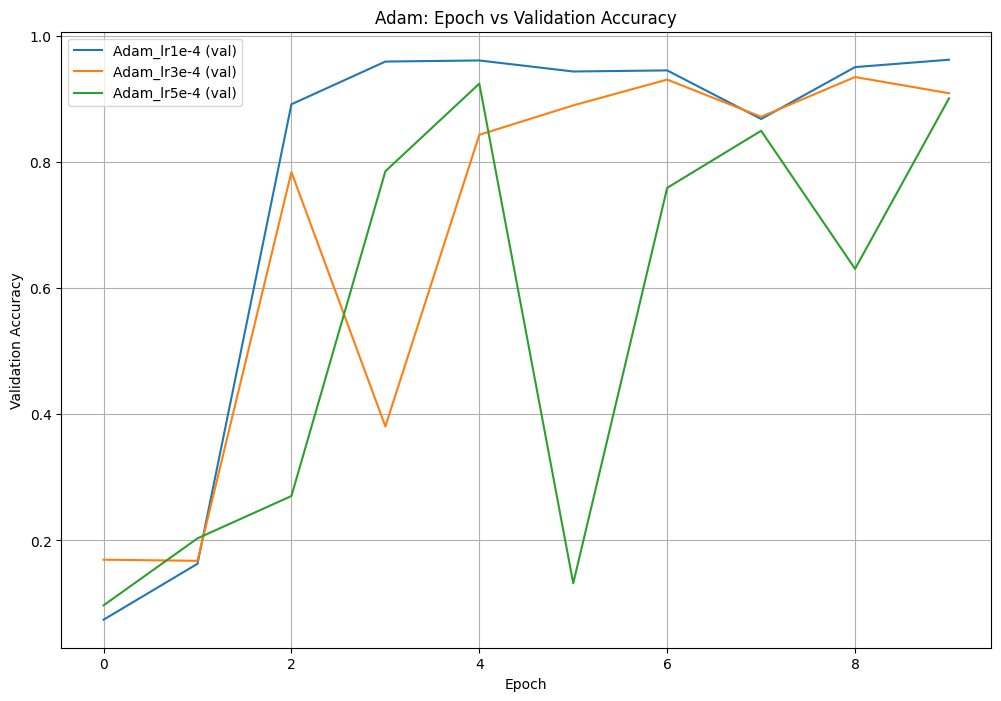

In [31]:
# Adam: Epoch vs Validation Accuracy

plt.figure(figsize=(12, 8))

for name, info in histories_50_64.items():
    history = info['history']
    plt.plot(history.history['val_accuracy'], label=f'{name} (val)')

plt.title('Adam: Epoch vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Evaluation: Adam, lr = 1e-4
model_50_64 = histories_50_64['Adam_lr1e-4']['model']

y_prob_50_64 = model_50_64.predict(test_generator_64)
y_pred_50_64 = np.argmax(y_prob_50_64, axis=1)
y_true_64 = test_labels_64

label_dict = {
    "0": "neutrophil",
    "1": "eosinophil",
    "2": "basophil",
    "3": "lymphocyte",
    "4": "monocyte",
    "5": "immature granulocyte",
    "6": "erythroblast",
    "7": "platelet"
}
class_names = [label_dict[str(i)] for i in range(8)]


print(classification_report(y_true_64, y_pred_50_64, target_names=class_names))

107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step
                      precision    recall  f1-score   support

          neutrophil       0.90      0.99      0.94       244
          eosinophil       0.99      0.99      0.99       624
            basophil       0.99      0.96      0.98       311
          lymphocyte       0.94      0.87      0.91       579
            monocyte       0.99      0.97      0.98       243
immature granulocyte       0.91      0.97      0.94       284
        erythroblast       0.96      0.98      0.97       666
            platelet       1.00      1.00      1.00       470

            accuracy                           0.96      3421
           macro avg       0.96      0.97      0.96      3421
        weighted avg       0.96      0.96      0.96      3421



In [35]:
cm_50_64 = confusion_matrix(y_true_64, y_pred_50_64)
per_class_acc_50_64 = cm_50_64.diagonal() / cm_50_64.sum(axis=1)
for i, acc in enumerate(per_class_acc_50_64):
    print(f"{class_names[i]:<20s} accuracy: {acc:.4f}")

neutrophil           accuracy: 0.9918
eosinophil           accuracy: 0.9904
basophil             accuracy: 0.9646
lymphocyte           accuracy: 0.8739
monocyte             accuracy: 0.9671
immature granulocyte accuracy: 0.9683
erythroblast         accuracy: 0.9760
platelet             accuracy: 1.0000


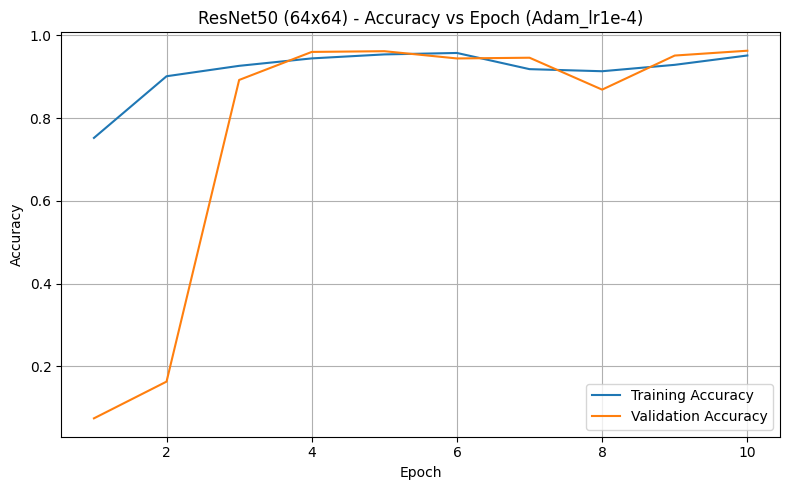

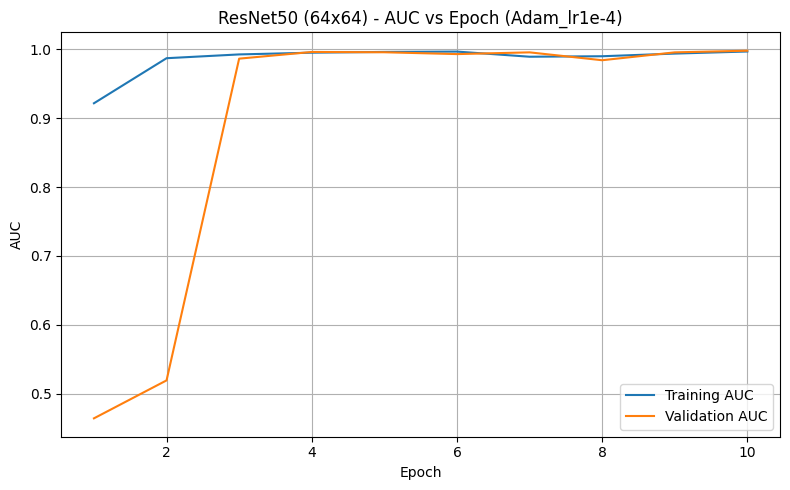

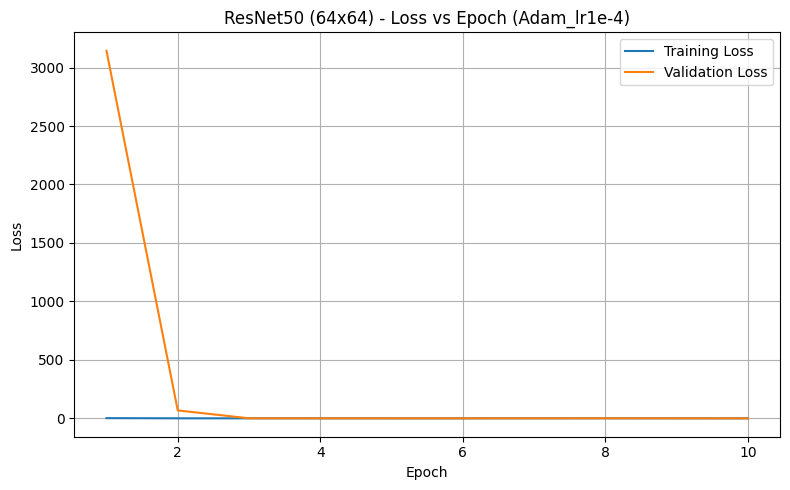

In [36]:
epochs = range(1, len(histories_50_64['Adam_lr1e-4']['history'].history['loss']) + 1)

# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['accuracy'], label='Training Accuracy')
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 (64x64) - Accuracy vs Epoch (Adam_lr1e-4)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# AUC
plt.figure(figsize=(8, 5))
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['auc'], label='Training AUC')
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['val_auc'], label='Validation AUC')
plt.title('ResNet50 (64x64) - AUC vs Epoch (Adam_lr1e-4)')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['loss'], label='Training Loss')
plt.plot(epochs, histories_50_64['Adam_lr1e-4']['history'].history['val_loss'], label='Validation Loss')
plt.title('ResNet50 (64x64) - Loss vs Epoch (Adam_lr1e-4)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Comparison: RMSprop with different learning rates

# dictionary to store history for ResNet50 (64x64)

print("ResNet50 (64x64): RMSprop with different learning rates, batch size 32, dropout rate 0.4") 

histories_50_64_res = {}

# now trying different learning rates too
optimizers = {
    # "Adam_lr1e-4": Adam(learning_rate=1e-4),
    # "Adam_lr3e-4": Adam(learning_rate=3e-4),
    # "Adam_lr5e-4": Adam(learning_rate=5e-4),
    "RMSprop_lr1e-4": RMSprop(learning_rate=1e-4),
    "RMSprop_lr3e-4": RMSprop(learning_rate=3e-4),
    "RMSprop_lr5e-4": RMSprop(learning_rate=5e-4)
}


for name, optimizer in optimizers.items():
    print(f"\n Training with {name}")

    # define model
    base = ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(64, 64, 3)
    )

    x = base.output

    # prepare attention layer
    x_reshape = layers.Reshape((-1, x.shape[-1]))(x)
    attention = layers.Attention()([x_reshape, x_reshape])
    attention_output = layers.Reshape(x.shape[1:])(attention)

    x = layers.Multiply()([x, attention_output])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)

    output = layers.Dense(8, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=output)

    # compile model
    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy", AUC(name="auc", multi_label=True, num_labels=8)]
    )

    # compute class weights
    class_weights = compute_class_weight(class_weight="balanced", 
                                         classes=np.unique(train_labels_64), 
                                         y=train_labels_64)
    class_weight_dict = dict(enumerate(class_weights))

    # train
    history_50_64_res = model.fit(
        train_generator_64,
        epochs=10,
        validation_data=val_generator_64,
        class_weight=class_weight_dict,
        verbose=1
    )

    # evaluate
    test_loss, test_acc, test_auc = model.evaluate(test_generator_64)
    
    print(f"{name} - Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

    # save results
    histories_50_64_res[name] = {
        "history": history_50_64_res,
        "test_acc": test_acc,
        "test_auc": test_auc,
        "model": model  
    }

ResNet50 (64x64): RMSprop with different learning rates, batch size 32, dropout rate 0.4

 Training with RMSprop_lr1e-4


2025-04-26 19:20:24.223908: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10


/shared/home/tzj255/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


374/374 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - accuracy: 0.6506 - auc: 0.8577 - loss: 3.5171 - val_accuracy: 0.1945 - val_auc: 0.5000 - val_loss: 140564.8438
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.9219 - auc: 0.9891 - loss: 0.3120 - val_accuracy: 0.2155 - val_auc: 0.5476 - val_loss: 259.6803
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.9518 - auc: 0.9941 - loss: 0.1664 - val_accuracy: 0.8487 - val_auc: 0.9347 - val_loss: 2.4154
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.9623 - auc: 0.9968 - loss: 0.6670 - val_accuracy: 0.9381 - val_auc: 0.9774 - val_loss: 0.3902
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.9640 - auc: 0.9960 - loss: 0.1964 - val_accuracy: 0.9521 - val_auc: 0.9836 - val_loss: 17.3266
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 700s 2s/step - accuracy: 0.9677 - auc: 0.9977 - loss: 0.1118 - val_accuracy: 0.9585 - val_auc: 0.9923 - val_loss: 24.2220
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━